# Image segmentation

Image an image classification task, the network assigns a label (or class) to each input image. To know the shape of that object, which pixel belongs to which object, etc. You need to assign a class to each pixel of the image--this task is known as segmentation.

A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging, just to nmae a few.

This tutorials uses the. The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

- Class 1: Pixel belonging to the pet.
- Class 2: Pixwl bordering the pet.
- Class 3: None of the above/a sorrounding pixel.

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tf_keras

2025-04-17 22:42:21.080534: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 22:42:21.087237: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 22:42:21.107578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744909941.141025  810628 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744909941.151604  810628 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744909941.174637  810628 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

### Download the Oxford-IIIT Pets dataset

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

2025-04-17 22:42:27.135364: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
def normaliza(input_image, input_mask):
    inupt_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [5]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(
        datapoint['segmentation_mask'],
        (128, 128),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

    input_image, input_mask = normaliza(input_image, input_mask)
    return input_image, input_mask


In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_images = dataset['train'].map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE,
)
test_images = dataset['test'].map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)

In [8]:
class Augment(tf_keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf_keras.layers.RandomFlip(mode='horizontal', seed=seed)
        self.augment_labels = tf_keras.layers.RandomFlip(mode='horizontal', seed=seed)
        
    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [9]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    
    title = ['Input Image', "True Mask", "Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf_keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

2025-04-17 22:42:28.193381: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


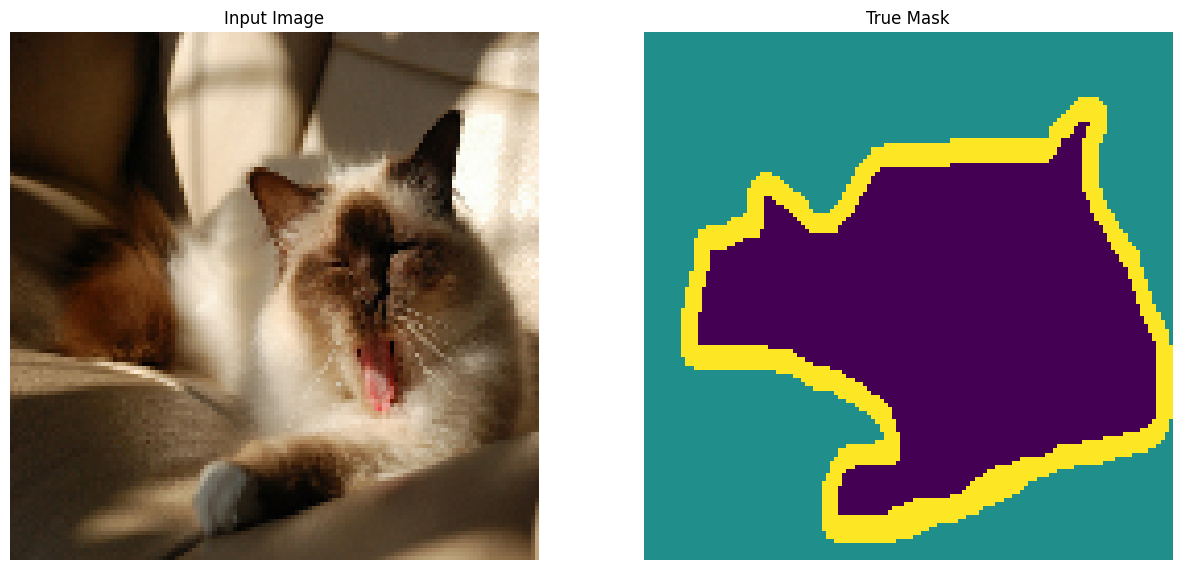

2025-04-17 22:42:29.888075: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


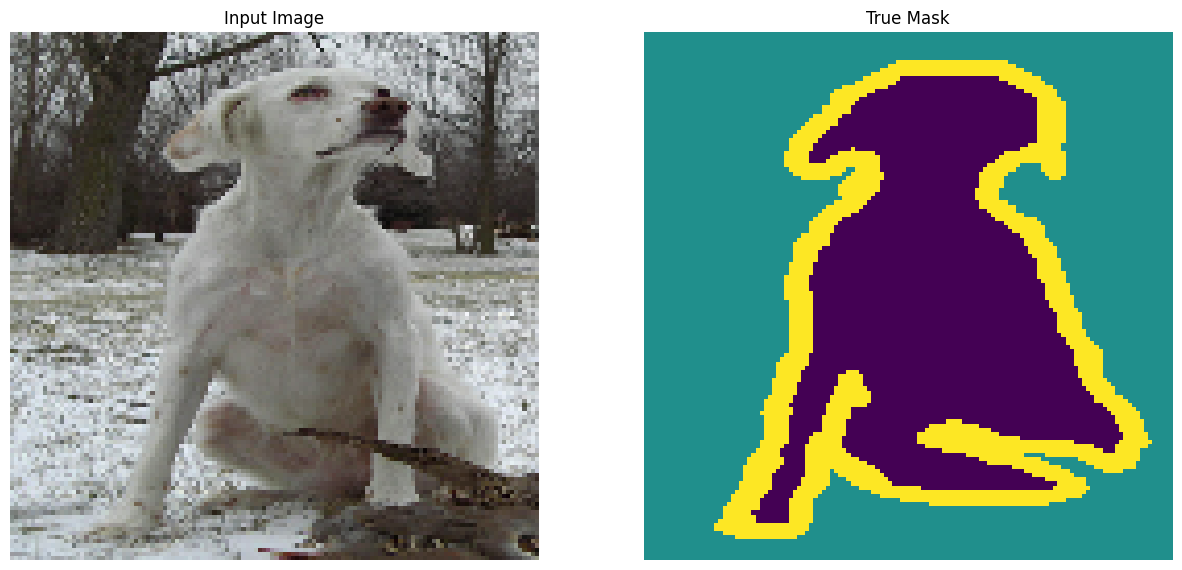

2025-04-17 22:42:30.031517: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

### Define the model